In [ ]:
! sudo pip install pulp networkx
import pulp as plp
import networkx as nx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 35.6 MB/s eta 0:00:00


In [ ]:
def draw(LUKI, ZRODLO, UJSCIE, KOSZTY, xs):
  positions = {
    "v1": (0,0),
    "v2": (1,0),
    "v3": (2,1),
    "v4": (2,-1),
    "v5": (3,0)
}
  graph1 = nx.DiGraph(LUKI)

  color_map = []
  for node in graph1.nodes:
    if node == ZRODLO or node == UJSCIE:
      color_map.append('aqua')
    else:
      color_map.append('lime')

  nx.draw(
        graph1,
        node_color = color_map,
        node_size = 1000,
        with_labels = True,
        pos = positions
      )

  for u, v, d in graph1.edges(data='koszt'):
    graph1.edges[u,v]['koszt'] = KOSZTY[(u,v)]

  edge_labels = {
      (u,v):
      ''.join(
          map(
            lambda x: f'{x[0]}={x[1]}',
            d.items()
            )
          )
        for u, v, d in graph1.edges(data=True)
        }

  nx.draw_networkx_edge_labels(
        graph1,
        edge_labels = edge_labels,
        pos = positions
      )
  edgelist = []
  for i in range(len(vs)):
    if vs[i].value() > 0:
      edgelist.append(LUKI[i])
  nx.draw_networkx_edges(graph1, pos=positions, edgelist=edgelist, edge_color='red', width=3)


In [ ]:
from typing import Any, List, Tuple, Dict

WOLUMEN_RUCHU = 100

def model4(WIERZCHOLKI: List[str], LUKI: List[Tuple[int, int]], KOSZTY: Dict[str, Any], ZRODLO: str, UJSCIE: str) -> plp.LpProblem:

  model = plp.LpProblem(name = 'model4', sense = plp.LpMinimize)
  SASIEDZTWA = dict(zip(
      WIERZCHOLKI, [[luk[1] for luk in LUKI if luk[0] == wierzcholek] for wierzcholek in WIERZCHOLKI]
      ))

  # Zdefiniowanie zmiennych i podstawowe ograniczenia
  xs = plp.LpVariable.dicts(
      "Przepływ_na_łączu_miedzy_wierzcholkami",
      {(v,w) for v in WIERZCHOLKI for w in WIERZCHOLKI if w in SASIEDZTWA[v]},
      0,
      WOLUMEN_RUCHU
    )

  # Funkcja celu:
  model.setObjective(plp.lpSum(KOSZTY[luk]*xs[luk] for luk in LUKI))
  # Wolumen ruchu wypływa ze źródła:
  model.add(plp.lpSum(xs[luk] for luk in LUKI if luk[0] is ZRODLO) == WOLUMEN_RUCHU)
  # Znajdźmy wierzczhołki pośredniczące
  POSREDNICZACE = [w for w in WIERZCHOLKI if w is not ZRODLO and w is not UJSCIE]
  # Prawo Kirchhoffa
  for wierzcholek in POSREDNICZACE:
    model += plp.lpSum(xs[luk] for luk in LUKI if luk[1] == wierzcholek) == plp.lpSum(
        xs[luk] for luk in LUKI if luk[0] == wierzcholek)

  return model

## Testowanie na grafie z wykładu

In [ ]:
# Testowanie na grafie z wykladu
WIERZCHOLKI = [
    "v1",
    "v2",
    "v3",
    "v4",
    "v5"
]

# Zbiór łuków/łączy, określonych jako pary wierzchołków:
LUKI = [
    ("v1","v2"),
    ("v1","v3"),
    ("v1","v4"),
    ("v2","v3"),
    ("v2","v4"),
    ("v3","v4"),
    ("v3","v5"),
    ("v4","v5"),
]

ZRODLO = "v1"
UJSCIE = "v5"

KOSZT_LUKI = [15, 9, 27, 5, 17, 11, 26, 14]
zip_iterator = zip(LUKI,KOSZT_LUKI)
KOSZTY = dict(zip_iterator)

m = model4(WIERZCHOLKI, LUKI, KOSZTY, ZRODLO, UJSCIE)
m.solve()
print("Rozwiązanie?", plp.LpStatus[m.status],"\n")
vs = m.variables()
for variable in vs:
  print(variable.name, variable.value())

Rozwiązanie? Optimal 

Przepływ_na_łączu_miedzy_wierzcholkami_('v1',_'v2') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v1',_'v3') 100.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v1',_'v4') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v2',_'v3') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v2',_'v4') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v3',_'v4') 100.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v3',_'v5') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v4',_'v5') 100.0


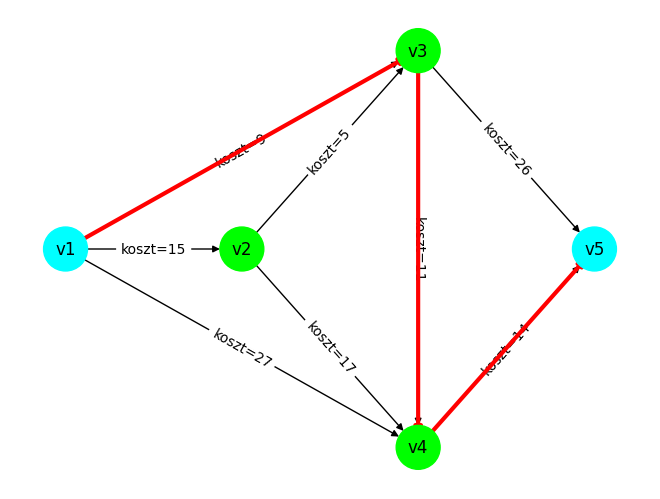

In [ ]:
draw(LUKI, ZRODLO, UJSCIE, KOSZTY, vs)

## Testowanie na nowym prostym grafie

In [ ]:
# Testowanie na nowym prostym grafie
WIERZCHOLKI = [
    "v1",
    "v2",
    "v3",
    "v4",
    "v5"
]

# Zbiór łuków/łączy, określonych jako pary wierzchołków:
LUKI = [
    ("v1","v2"),
    ("v1","v3"),
    ("v2","v5"),
    ("v3","v4"),
    ("v4","v2"),
    ("v4","v5"),
]

ZRODLO = "v1"
UJSCIE = "v5"

KOSZT_LUKI = [2, 3, 8, 10, 2, 11]
zip_iterator = zip(LUKI,KOSZT_LUKI)
KOSZTY = dict(zip_iterator)

m = model4(WIERZCHOLKI, LUKI, KOSZTY, ZRODLO, UJSCIE)
m.solve()
print("Rozwiązanie?", plp.LpStatus[m.status],"\n")
vs = m.variables()
for variable in vs:
  print(variable, variable.value())


Rozwiązanie? Optimal 

Przepływ_na_łączu_miedzy_wierzcholkami_('v1',_'v2') 100.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v1',_'v3') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v2',_'v5') 100.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v3',_'v4') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v4',_'v2') 0.0
Przepływ_na_łączu_miedzy_wierzcholkami_('v4',_'v5') 0.0


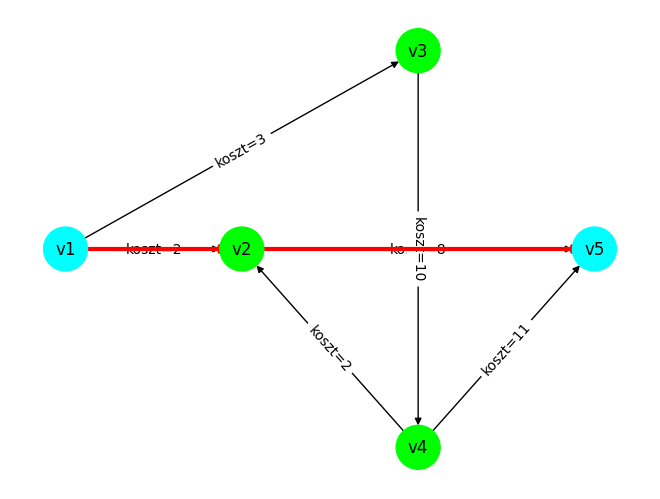

In [ ]:
draw(LUKI, ZRODLO, UJSCIE, KOSZTY, vs)

Dziękuję za uwagę :)